### Loading the model

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()



In [2]:
model = tf.keras.models.load_model("mnist-99-tensorflow2-default-v1/best_model.h5")

## Data preprocessing 

### importing opencv

In [3]:
import cv2

### importing numpy

In [4]:
import numpy as np

In [5]:
def preprocess_image(image_path):
    image= cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"image not found at path {image_path}")
    
    #resize image to be 28 * 28 pixels 
    
    image = cv2.resize(image, (28,28))
    
    # Normalize pixel values to be in the range [0,1]
    image = image /255.0
    
    # expand the dimesion to match the input shape 
    image = np.expand_dims(image,axis=-1) # add channel dimesion
    image = np.expand_dims(image,axis=0) # add batch dimesion 
    
    return image.astype(np.float32)

## importing matplot lib for showing image/ displaying image

In [6]:
def modified_preproccessing(image_path):
    image= cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError(f"image not found at path {image_path}")
    
     # Denoise the image (Gaussian blur to reduce noise)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    
        # Resize image to 28x28 pixels (with anti-aliasing)
    image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
        # Normalize pixel values to range [-1, 1]
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    
        # Optionally apply adaptive histogram equalization for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply((image * 127.5 + 127.5).astype(np.uint8))  
    
        # Expand dimensions to match the input shape of the model
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)   # Add batch dimension
    
    return image.astype(np.float32)



In [7]:
import matplotlib.pyplot as plt

In [8]:
def show_image(image_file,title="original image",cmap=None):
  plt.imshow(image_file,cmap=cmap)
  plt.title(title)
  plt.axis("off")
  plt.show()

In [17]:
image_path = "numbers/four2.jpeg"
org_img= cv2.imread(image_path)

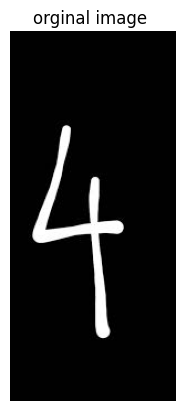

In [18]:
show_image(org_img,"orginal image ")


### displaying the preproccessed image

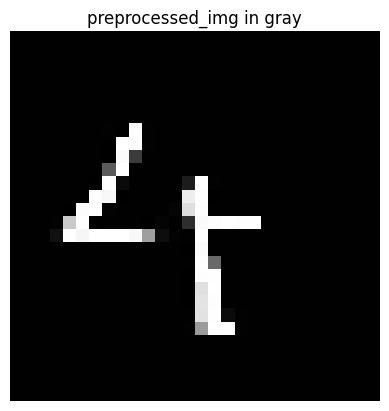

In [19]:
preprocessed_img=preprocess_image(image_path)
# print(preprocess_image)
image_for_display = preprocessed_img[0, :, :, 0]  # Shape becomes [28, 28] for [1,28,28,1]
show_image(image_for_display,"preprocessed_img in gray",cmap="gray")

In [12]:
# preproccessed_image_2= modified_preproccessing(image_path)

# image_for_display_2= preproccessed_image_2[0,:,:,0]
# show_image(image_for_display_2,"modified_preproccessing in gray",cmap="gray")


### Testing with abenis model

In [20]:
# tf.compat.v1.enable_eager_execution()
# preprocessed_image_2_np = np.array(list(preproccessed_image_2))
predictions=model.predict(preprocessed_img)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[2.9362363e-10 3.1728258e-09 1.0920318e-07 1.0354457e-12 9.9998701e-01
  4.2898782e-09 1.2847196e-05 1.5406661e-08 1.3575703e-08 4.1585885e-10]]


In [21]:
# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[4]


## Another model

### Wrap tensorFlow hub module in tf.keras and export

In [37]:
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub

### inspecting to find the tensor names  

In [38]:

tf.disable_eager_execution()

def list_tensors_saved_model(saved_model_dir):
    with tf.Session(graph=tf.Graph()) as sess:
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], saved_model_dir)
        for op in sess.graph.get_operations():
            print(op.name)

SAVED_MODEL_DIR = "./model_2"  # Path to the folder containing saved_model.pb
list_tensors_saved_model(SAVED_MODEL_DIR)


INFO:tensorflow:Restoring parameters from ./model_2/variables/variables


INFO:tensorflow:Restoring parameters from ./model_2/variables/variables


NoOp
Const
saver_filename
StatefulPartitionedCall
StatefulPartitionedCall_1


In [39]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from tensorflow.python.saved_model import tag_constants

# Path to the saved model
saved_model_dir = './model'

# Load the model
with tf.Session() as sess:
    # Load the saved model with the "serve" tag (or any appropriate tag)
    tf.saved_model.loader.load(sess, [tag_constants.SERVING], saved_model_dir)

    # After loading the model, you can get the tensor names
    # Get the graph definition
    graph = tf.get_default_graph()

    # Inspect tensor names
    for op in graph.get_operations():
        print(op.name)




OSError: SavedModel file does not exist at: ./model/{saved_model.pbtxt|saved_model.pb}

In [16]:
## define a wrapper model

def build_model():
    # Define the input layer
    input_tensor = tf.keras.layers.Input(shape=(28, 28, 1), dtype=tf.float32, name="input_tensor")
    
    # Define the hub layer
    hub_layer = hub.KerasLayer(
        'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4',  # Example TensorFlow Hub model
        trainable=False
    )
    
    # Pass input_tensor through the hub_layer
    logits = hub_layer(input_tensor)
    
    # Add a Softmax activation layer for probabilities
    output_tensor = tf.keras.layers.Softmax()(logits)
    
    return tf.keras.Model(inputs=input_tensor, outputs=output_tensor)






### Build the new model

In [17]:
new_model = build_model()

ValueError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=input_tensor>
  • training=None

### saving th model in a saved model format

In [ ]:
model.save ("mnist_model_new", save_format="tf")